___
<center><em>Copyright Pierian Data</em></center>

In [425]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [426]:
df = pd.read_csv('../input/frozen-dessert-production/Frozen_Dessert_Production.csv', parse_dates=True, index_col='DATE')
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [427]:
df.columns = ['Production']

In [428]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


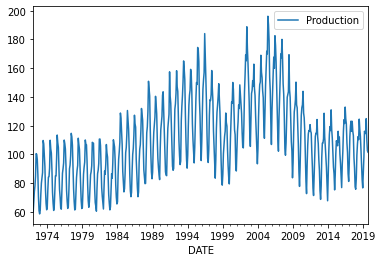

In [429]:
df.plot();

## Train Test Split

In [430]:
df.shape

(573, 1)

In [431]:
# Split the data into a train/test
test_size = 24
test_split_ind = len(df) - test_size
train = df.iloc[:test_split_ind]
test = df.iloc[test_split_ind:]
train.shape, test.shape

((549, 1), (24, 1))

## Scale Data

In [432]:
from sklearn.preprocessing import MinMaxScaler

train_scaler = MinMaxScaler()
scaled_train = train_scaler.fit_transform(train)
scaled_test = train_scaler.transform(test)

In [433]:
# Create a TimeSeriesGenerator object based off the scaled_train data.
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 18

train_generator = TimeseriesGenerator(data=scaled_train,
                                      targets=scaled_train,
                                      length=length,
                                      batch_size=1)

In [434]:
# Create a Keras Sequential Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

n_features = 1

model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [435]:
# Create an EarlyStopping callback based on val_loss
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [436]:
# Create a generator for the scaled test/validation set
val_genetor = TimeseriesGenerator(data=scaled_test, 
                                  targets=scaled_test,
                                  length=length,
                                  batch_size=1)

**TASK: Fit the model to the generator, let the EarlyStopping dictate the amount of epochs, so feel free to set the parameter high.**

In [437]:
# Fit the model to the generator

model.fit_generator(generator=train_generator,
                    epochs=20,
                    callbacks=[early_stopping],
                    validation_data=val_generator,)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
531/531 [==============================] - 5s 7ms/step - loss: 0.0314 - val_loss: 0.0030
Epoch 2/20
531/531 [==============================] - 3s 6ms/step - loss: 0.0100 - val_loss: 0.0017
Epoch 3/20
531/531 [==============================] - 3s 6ms/step - loss: 0.0075 - val_loss: 0.0019
Epoch 4/20
531/531 [==============================] - 3s 6ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 5/20
531/531 [==============================] - 3s 6ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 6/20
531/531 [==============================] - 3s 6ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 7/20
531/531 [==============================] - 3s 6ms/step - loss: 0.0038 - val_loss: 0.0017


In [438]:
stopped_epoch = early_stopping.stopped_epoch
stopped_epoch

6

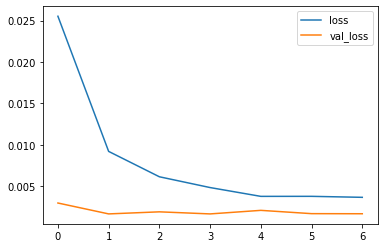

In [439]:
# Plot the history of the loss that occured during training
losses = model.history.history
pd.DataFrame(losses).plot();

## Evaluate on Test Data

**TASK: Forecast predictions for your test data range (the last 12 months of the entire dataset). Remember to inverse your scaling transformations. Your final result should be a DataFrame with two columns, the true test values and the predictions.**

In [440]:
# Evauate on test data
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for _ in range(len(scaled_test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='DATE'>

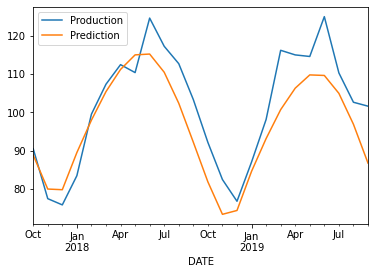

In [441]:
# Plot your predictions versus the True test values
true_predcitions = train_scaler.inverse_transform(test_predictions)
test['Prediction'] = true_predcitions
test.plot()

**TASK: Calculate your RMSE.**

In [442]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test['Production'], test['Prediction']))
rmse

8.003854037036069

## Forecast on full data

In [443]:
full_scaler = MinMaxScaler()

scaled_df = full_scaler.fit_transform(df)

In [444]:
length = 18
batch_size = 1

full_generator = TimeseriesGenerator(data=scaled_df,
                                     targets=scaled_df,
                                     length=length,
                                     batch_size=batch_size)

In [445]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [446]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [447]:
model.fit_generator(generator=full_generator, epochs=stopped_epoch)

Epoch 1/6


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


555/555 [==============================] - 4s 6ms/step - loss: 0.0418
Epoch 2/6
555/555 [==============================] - 3s 6ms/step - loss: 0.0162
Epoch 3/6
555/555 [==============================] - 3s 6ms/step - loss: 0.0053
Epoch 4/6
555/555 [==============================] - 3s 6ms/step - loss: 0.0040
Epoch 5/6
555/555 [==============================] - 3s 6ms/step - loss: 0.0035
Epoch 6/6
555/555 [==============================] - 3s 6ms/step - loss: 0.0031


In [448]:
scaled_forecasts = []

first_forecast_batch = scaled_df[-length:]

current_batch = first_forecast_batch.reshape((1, length, n_features))

periods = 24

for _ in range(periods):
    
    current_forecast = model.predict(current_batch)[0]
    
    scaled_forecasts .append(current_forecast)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_forecast]],axis=1)  
    

In [449]:
forecats = full_scaler.inverse_transform(scaled_forecasts)
forecats

array([[ 91.97843081],
       [ 87.60042312],
       [ 89.82254684],
       [ 98.94802208],
       [109.76920704],
       [118.94770523],
       [125.12973895],
       [128.00635467],
       [126.86146394],
       [121.45588155],
       [112.43712431],
       [102.57839312],
       [ 94.99048906],
       [ 92.81907278],
       [ 98.22768786],
       [108.77556162],
       [119.82423542],
       [128.97053789],
       [134.95855713],
       [137.21869197],
       [135.04680849],
       [128.20852053],
       [118.23461258],
       [107.58713945]])

In [450]:
last_sale = df.index.max()
first_forecast_ind = last_sale + pd.DateOffset(months=1)
last_sale, first_forecast_ind

(Timestamp('2019-09-01 00:00:00'), Timestamp('2019-10-01 00:00:00'))

In [451]:
forecast_ind = pd.date_range(start=first_forecast_ind, 
                             periods=periods,
                             freq='MS')
forecast_ind

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [456]:
forecasts_df = pd.DataFrame(forecats, index=forecast_ind, columns=['Production'])
forecasts_df['flag'] = True
df['is_forecast'] = False

In [457]:
df.tail(2)

,Production,is_forecast
DATE,,
2019-08-01,102.6085,False
2019-09-01,101.5866,False


In [458]:
forecasts_df.head(2)

,Production,flag
2019-10-01,91.978431,True
2019-11-01,87.600423,True


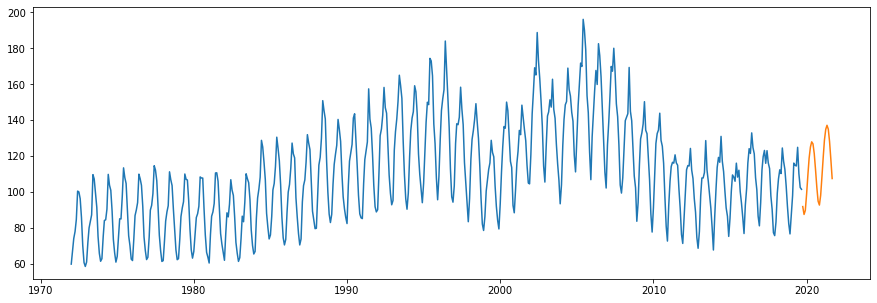

In [461]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['Production'])
ax.plot(forecasts_df['Production'])
plt.show()